# Using the TFA toolbox

   Imports:

In [1]:
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import swarmpal.toolboxes.tfa.tfa_processor as tfa

Provide values for the parameters of the analysis.  The `dataset` can be chosen from one of the compatible magnetic data collections, and the `var` is a VirES-compatible variable string (see [viresclient](https://viresclient.readthedocs.io/en/latest/available_parameters.html) for more information). The "start" and "end" times must be given as a datetime object. If the data are required as they are, set the `remove_chaos_model` parameter to False. Otherwise, if the inputs are magnetic field data and the analysis requires subtraction of the model field, set the parameter to True. 

In [2]:
dataset = "SW_OPER_MAGA_LR_1B"
var = 'F'
remove_chaos_model = False
time_start = dt.datetime(2015, 3, 18)
time_end = dt.datetime(2015, 3, 18, 0, 15, 0)

Now run the TfaInput to retrieve the selected data.

In [3]:
inputs = tfa.TfaInput(collection = dataset, 
                start_time = time_start, end_time = time_end,
                initialise = True,
                varname=var, sampling_time = "PT1S",
                remove_chaos=remove_chaos_model)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (1.491MB)

In [4]:
#inputs.to_file('using_tfa.nc')
#inputs.initialise('using_tfa.nc')

The data now contains everything we need to start the processing. This data is contained in the `.xarray` attribute:

In [5]:
inputs.xarray

<xarray.Dataset>
Dimensions:     (Timestamp: 22500)
Coordinates:
  * Timestamp   (Timestamp) datetime64[ns] 2015-03-17T21:00:00 ... 2015-03-18...
Data variables:
    Spacecraft  (Timestamp) object 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    QDLat       (Timestamp) float64 13.01 12.94 12.88 ... 14.12 14.05 13.98
    QDLon       (Timestamp) float64 -130.7 -130.7 -130.7 ... 137.2 137.2 137.2
    Radius      (Timestamp) float64 6.833e+06 6.833e+06 ... 6.833e+06 6.833e+06
    Latitude    (Timestamp) float64 19.59 19.52 19.46 19.39 ... 19.76 19.7 19.63
    F           (Timestamp) float64 2.887e+04 2.886e+04 ... 3.328e+04 3.326e+04
    MLT         (Timestamp) float64 7.32 7.32 7.32 7.321 ... 7.391 7.391 7.391
    Longitude   (Timestamp) float64 158.1 158.1 158.1 ... 64.01 64.01 64.01
    Flags_F     (Timestamp) uint8 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
Attributes:
    Sources:         ['SW_OPER_MAGA_LR_1B_20150317T000000_20150317T235959_060...
    MagneticModels:  []
    AppliedFilters:  []

Let's first test the analysis with an artificial series, so we'll replace the `F` variable with a time series of our choice, with a specific frequency of 40 mHz (i.e. 25 sec) and amplitude of 4 nT. 

To test the cleaning we'll add some random spikes as well

In [6]:
N = inputs.xarray['F'].shape[0] # get the length of the data
test_wave = 4 * np.sin(2*np.pi*np.arange(N)/50)
#test_wave = np.ones(N)

# create ten spikes at ten random locations
spike_locations = np.random.randint(0, 1000, 10) + int(N/2) - 500
test_wave[spike_locations] = test_wave[spike_locations] + 4
inputs.xarray['F'].data = test_wave

To use the processing capabilities of TFA we create a `TfaProcessor` object, that contains the variable of choice.

In [7]:
processor = tfa.TfaProcessor(inputs, active_variable={"varname": var})

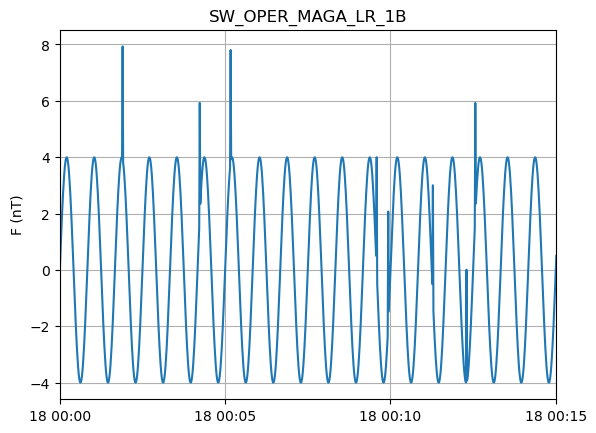

In [8]:
processor.plotX()

To perform cleaning on the data, we initialize a `Cleaning` object with the parameters of our choice and then apply it on the data with the `TfaProcessor` `apply()` function.
The active variable series can be plotted by means of the `plotX()` function.

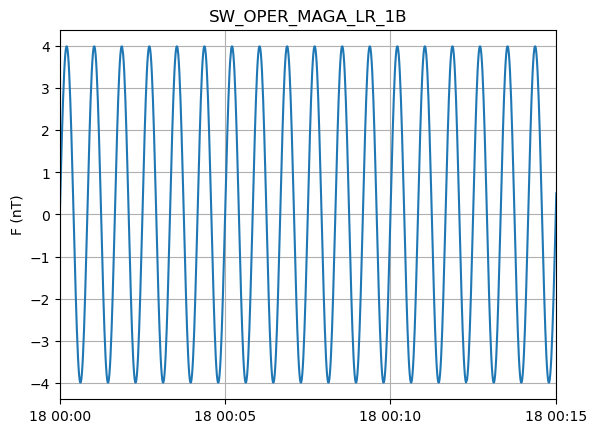

In [9]:
c = tfa.Cleaning()
processor.apply(c)
processor.plotX()

Similarly, the filtering can be performed by first initializing a `Filtering` object with the parameters of our choosing and the applying in on the data.

In [10]:
f = tfa.Filtering()
processor.apply(f)

In the same way, the wavelet transform is applied

In [11]:
w = tfa.Wavelet()
processor.apply(w)

The result of the wavelet can be visualized by means of the `image()` function. Set the `log` parameter to True to plot the log-10 of the results or False to plot them as they are. The optional parameter `cbar_lims` can be set to specify the limits of the colorbar for the spectral plot.

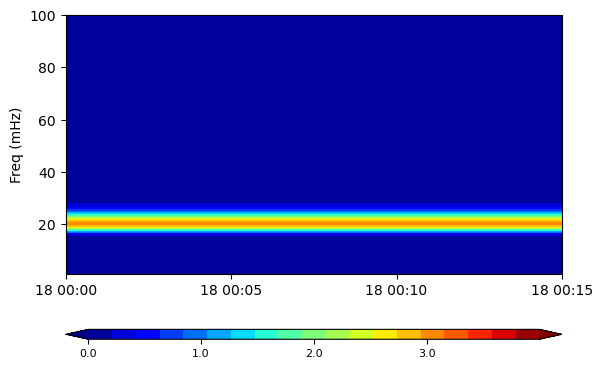

In [12]:
processor.image(log=False, cbar_lims=[0, 4])

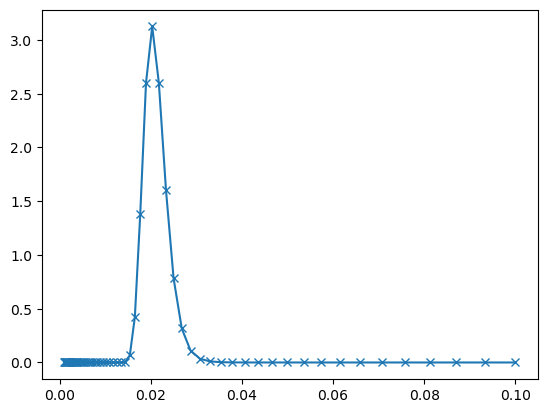

In [13]:
#plt.plot(1/processor.input_data.xarray['scale'].data)
#scale.sum(processor.input_data.xarray['W'][:,11000].data)*0.1
plt.plot(1/processor.input_data.xarray['scale'].data, processor.input_data.xarray['W'][:,int(N/2)], '-x')

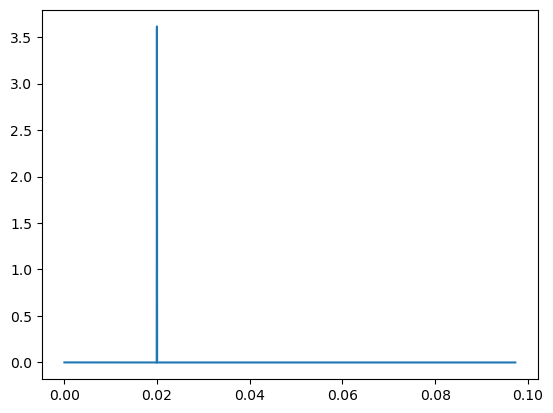

In [14]:
fft_freq = np.arange(1, 2190)/N
F = np.abs(np.fft.fft(processor.input_data.xarray['X'].data)[1:2190])/(N/2)
plt.plot(fft_freq, F)

In [15]:
(np.sum(processor.input_data.xarray['W'].data[:,int(N/2)]), np.sum(F**2))

(13.05945884874528, 13.05827033669123)

The same result holds even if one changes the frequency resolution.

13.059456007882543

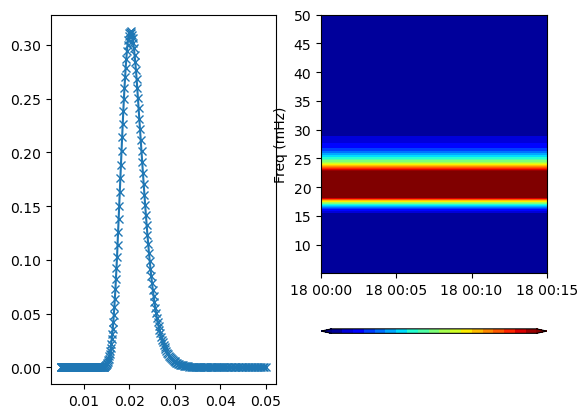

In [17]:
w = tfa.Wavelet({'Time_Step': processor.input_data.SAMPLING_TIME, 'Min_Scale': 1000/50, 'Max_Scale': 1000/5, 'dj': 0.01})
processor.apply(w)
plt.subplot(1,2,1)
plt.plot(1/processor.input_data.xarray['scale'].data, processor.input_data.xarray['W'][:,int(N/2)], '-x')
plt.subplot(1,2,2)
processor.image(log=False, cbar_lims=[0, .2])
np.sum(processor.input_data.xarray['W'].data[:,int(N/2)])